In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import json
import pandas as pd
import os
import seaborn as sns


In [2]:
import wandb 

api = wandb.Api()

In [3]:
def get_metrics(api_path):
    run = api.run(api_path)
    summary = run.summary
    class_dice = {}
    for key, value in summary.items():
        if "val" in key :
            if "dice" in key or "loss" in key:
                continue
            class_dice[key.split("/")[1]] = value
    return run, summary, class_dice

In [4]:
# Project is specified by <entity/project-name>
runs = api.runs("lv2-ss-/semantic-segmentation")

name_list, id_list, config_list = [], [], []
for run in runs: 
    # run id 
    id_list.append(run.id)
    # .name is the human-readable name of the run.
    name_list.append(run.name)
    config_list.append(run.config)

runs_df = pd.DataFrame({
    "name": name_list,
    "id": id_list,
    "config": config_list
    })


In [5]:
runs_df

,name,id,config
0,fcn_resnet50,mdrig7a4,"{'LR': 0.0001, 'EPOCHS': 5, 'VAL_EVERY': 5, 'B..."
1,fcn_resnet50_baseline,ic3wz60r,"{'LR': 0.0001, 'EPOCHS': 2, 'CSV_NAME': 'valid..."
2,fcn_resnet50_baseline,2ef5a6eg,"{'LR': 0.0001, 'EPOCHS': 2, 'CSV_NAME': 'valid..."
3,model_module_test,r2vjlrxb,"{'LR': 0.0001, 'FP16': False, 'EPOCHS': 5, 'VA..."
4,fcn_resnet50_resize1024,akyhzv2u,"{'LR': 0.0001, 'EPOCHS': 30, 'CSV_NAME': 'vali..."
...,...,...,...
82,28.5_DeepLabv3_Xception71,1ccpsq5w,"{'LR': 0.0075, 'FP16': True, 'EPOCHS': 30, 'CS..."
83,28.6_DeepLabv3_Xception71,mmdv8lhf,"{'LR': 0.005, 'FP16': True, 'EPOCHS': 75, 'CSV..."
84,Filter_data_UppE8,fyrro2d2,"{'LR': 0.005, 'FP16': True, 'EPOCHS': 45, 'VAL..."
85,3_decoder_linknet_0.003,g6q3hs3y,"{'LR': 0.003, 'FP16': True, 'LOSS': {'NAME': '..."


In [6]:

decoder_list = ['6gz19wq1', 'relv9x3i', '8mimmy55', '667ft0ud', 'i1sgb4te']
decoder_runs_df = runs_df[runs_df['id'].isin(decoder_list)]
# decoder_runs_df_d = decoder_runs_df.drop(decoder_runs_df.index[:6])
# decoder_runs_df_d = decoder_runs_df_d.drop(decoder_runs_df_d.index[2:4])
# decoder_runs_df_d
decoder_runs_df

,name,id,config
44,1_decoder_DLV3P,6gz19wq1,"{'LR': 0.005, 'FP16': True, 'LOSS': {'NAME': '..."
46,2_decoder_fpn,relv9x3i,"{'LR': 0.005, 'FP16': True, 'LOSS': {'NAME': '..."
51,6_decoder_unetplusplus,8mimmy55,"{'LR': 0.005, 'FP16': True, 'LOSS': {'NAME': '..."
53,7_decoder_pan,667ft0ud,"{'LR': 0.005, 'FP16': True, 'LOSS': {'NAME': '..."
56,26_decoder_DUCKNetDecoder,i1sgb4te,"{'LR': 0.005, 'FP16': True, 'LOSS': {'NAME': '..."


In [7]:
# smp runs 추출
encoder_runs_df = runs_df[runs_df['name'].str.contains('smp')]
encoder_runs_df

,name,id,config
7,smp_Unet_resnet101,2cd2stgd,"{'LR': 0.005, 'EPOCHS': 30, 'VAL_EVERY': 5, 'B..."
9,smp_Unet_resnext101_32x8d_testing,lv9hohx6,"{'LR': 0.005, 'EPOCHS': 30, 'VAL_EVERY': 5, 'B..."
13,smp_Unet_resnest101e,xt4fau1r,"{'LR': 0.005, 'FP16': True, 'EPOCHS': 30, 'VAL..."
14,smp_Unet_timm-res2net101_26w_4s,yyq5oaqm,"{'LR': 0.005, 'FP16': True, 'EPOCHS': 30, 'VAL..."
16,smp_Unet_timm-regnetx_120,tak8qx9z,"{'LR': 0.005, 'FP16': True, 'EPOCHS': 30, 'VAL..."
18,smp_Unet_timm-regnety_120,195av2mw,"{'LR': 0.005, 'FP16': True, 'EPOCHS': 30, 'VAL..."
19,smp_Unet_timm-gernet_l,emgzb1m1,"{'LR': 0.005, 'FP16': True, 'EPOCHS': 30, 'VAL..."
22,smp_Unet_inceptionresnetv2,rlhoi00u,"{'LR': 0.005, 'FP16': True, 'EPOCHS': 30, 'VAL..."
24,smp_Unet_timm-efficientnet-b8,ouvihcdz,"{'LR': 0.005, 'FP16': True, 'EPOCHS': 30, 'VAL..."
25,smp_Unet_dpn98,a16gite4,"{'LR': 0.005, 'FP16': True, 'EPOCHS': 30, 'VAL..."


In [8]:
# decoder_runs_df를 딕셔너리로 변환
decoder_runs_dict = decoder_runs_df.to_dict('records')
decoder_runs_dict
print(len(decoder_runs_dict))
# encoder_runs_df를 딕셔너리로 변환
encoder_runs_dict = encoder_runs_df.to_dict('records')
encoder_runs_dict
print(len(encoder_runs_dict))

5
11


In [11]:
encoder_api_paths = [f"lv2-ss-/semantic-segmentation/{id}" for id in encoder_runs_df['id'].tolist()]
encoder_api_paths

['lv2-ss-/semantic-segmentation/2cd2stgd',
 'lv2-ss-/semantic-segmentation/lv9hohx6',
 'lv2-ss-/semantic-segmentation/xt4fau1r',
 'lv2-ss-/semantic-segmentation/yyq5oaqm',
 'lv2-ss-/semantic-segmentation/tak8qx9z',
 'lv2-ss-/semantic-segmentation/195av2mw',
 'lv2-ss-/semantic-segmentation/emgzb1m1',
 'lv2-ss-/semantic-segmentation/rlhoi00u',
 'lv2-ss-/semantic-segmentation/ouvihcdz',
 'lv2-ss-/semantic-segmentation/a16gite4',
 'lv2-ss-/semantic-segmentation/5pzsgcih']

In [9]:
decoder_api_paths = [f"lv2-ss-/semantic-segmentation/{id}" for id in decoder_runs_df['id'].tolist()]
decoder_api_paths


['lv2-ss-/semantic-segmentation/6gz19wq1',
 'lv2-ss-/semantic-segmentation/relv9x3i',
 'lv2-ss-/semantic-segmentation/8mimmy55',
 'lv2-ss-/semantic-segmentation/667ft0ud',
 'lv2-ss-/semantic-segmentation/i1sgb4te']

In [12]:
for api_path, dic in zip(decoder_api_paths, decoder_runs_dict):
    run_dec, summary_dec, class_dice_dec = get_metrics(api_path)
    dic['class_dice'] = class_dice_dec
for api_path, dic in zip(encoder_api_paths, encoder_runs_dict):
    run_enc, summary_enc, class_dice_enc = get_metrics(api_path)
    dic['class_dice'] = class_dice_enc

print(len(decoder_runs_dict))
print(len(encoder_runs_dict))



5
11


In [13]:
enc_dict = []
for dic in encoder_runs_dict:
    print('name:', dic['name'], 'class_dice:', len(dic['class_dice'].keys()))
    if len(dic['class_dice'].keys()) == 0:
        continue
    enc_dict.append(dic)
    
dec_dict = []
for dic in decoder_runs_dict:
    print('name:', dic['name'], 'class_dice:', len(dic['class_dice'].keys()))
    if len(dic['class_dice'].keys()) == 0:
        continue
    dec_dict.append(dic)

print(len(enc_dict))
print(len(dec_dict))



name: smp_Unet_resnet101 class_dice: 0
name: smp_Unet_resnext101_32x8d_testing class_dice: 0
name: smp_Unet_resnest101e class_dice: 29
name: smp_Unet_timm-res2net101_26w_4s class_dice: 29
name: smp_Unet_timm-regnetx_120 class_dice: 29
name: smp_Unet_timm-regnety_120 class_dice: 29
name: smp_Unet_timm-gernet_l class_dice: 29
name: smp_Unet_inceptionresnetv2 class_dice: 29
name: smp_Unet_timm-efficientnet-b8 class_dice: 29
name: smp_Unet_dpn98 class_dice: 29
name: smp_Unet_mit_b5 class_dice: 29
name: 1_decoder_DLV3P class_dice: 29
name: 2_decoder_fpn class_dice: 29
name: 6_decoder_unetplusplus class_dice: 29
name: 7_decoder_pan class_dice: 29
name: 26_decoder_DUCKNetDecoder class_dice: 29
9
5


In [14]:
finger_classes = [f'finger-{i}' for i in range(1, 20)]
backhand_classes = [
    'Trapezium', 'Trapezoid', 'Capitate', 'Hamate',
    'Scaphoid', 'Lunate', 'Triquetrum', 'Pisiform']
wrist_classes = ['Radius', 'Ulna']
all_classes = finger_classes + wrist_classes + backhand_classes

In [15]:
def df_class_dice(name, class_dice):
    # dictionary를 데이터프레임으로 변환
    class_dice_df = pd.DataFrame({
        'class': list(class_dice.keys()),
        'dice': list(class_dice.values())
    })

    # 각 클래스의 타입(finger/wrist) 정보 추가
    class_dice_df['type'] = class_dice_df['class'].apply(lambda x: 'finger' if x.startswith('finger') else 'wrist' if x.startswith('Radius') or x.startswith('Ulna') else 'backhand')
    class_dice_df['name'] = name
    type_means = class_dice_df.groupby('type')['dice'].agg(['mean', 'std', 'min', 'max'])
    
    return class_dice_df, type_means


In [16]:

for dic in dec_dict:
    class_dice_df, type_means = df_class_dice(dic['name'], dic['class_dice'])

    if 'dec_class_dice_df' not in locals():
        dec_class_dice_df = class_dice_df
    else:
        dec_class_dice_df = pd.concat([dec_class_dice_df, class_dice_df], ignore_index=True)
    print('--------------------',dic['name'],'-------------------')
    print(class_dice_df)
    print("\nPerformance by Type:")
    print(type_means)

    # 상위/하위 5개 클래스
    print("\nTop 5 Best Performing Classes:")
    print(class_dice_df.nlargest(5, 'dice')[['class', 'dice', 'type']])

    print("\nTop 5 Worst Performing Classes:")
    print(class_dice_df.nsmallest(5, 'dice')[['class', 'dice', 'type']])

dec_class_dice_df

-------------------- 1_decoder_DLV3P -------------------
         class      dice      type             name
0     Capitate  0.941017  backhand  1_decoder_DLV3P
1       Hamate  0.926089  backhand  1_decoder_DLV3P
2       Lunate  0.926845  backhand  1_decoder_DLV3P
3     Pisiform  0.855876  backhand  1_decoder_DLV3P
4       Radius  0.981616     wrist  1_decoder_DLV3P
5     Scaphoid  0.939582  backhand  1_decoder_DLV3P
6    Trapezium  0.912467  backhand  1_decoder_DLV3P
7    Trapezoid  0.891094  backhand  1_decoder_DLV3P
8   Triquetrum  0.922044  backhand  1_decoder_DLV3P
9         Ulna  0.975587     wrist  1_decoder_DLV3P
10    finger-1  0.940805    finger  1_decoder_DLV3P
11   finger-10  0.972775    finger  1_decoder_DLV3P
12   finger-11  0.962924    finger  1_decoder_DLV3P
13   finger-12  0.938589    finger  1_decoder_DLV3P
14   finger-13  0.956651    finger  1_decoder_DLV3P
15   finger-14  0.968593    finger  1_decoder_DLV3P
16   finger-15  0.957666    finger  1_decoder_DLV3P
17   fi

,class,dice,type,name
0,Capitate,0.941017,backhand,1_decoder_DLV3P
1,Hamate,0.926089,backhand,1_decoder_DLV3P
2,Lunate,0.926845,backhand,1_decoder_DLV3P
3,Pisiform,0.855876,backhand,1_decoder_DLV3P
4,Radius,0.981616,wrist,1_decoder_DLV3P
...,...,...,...,...
140,finger-5,0.960480,finger,26_decoder_DUCKNetDecoder
141,finger-6,0.970462,finger,26_decoder_DUCKNetDecoder
142,finger-7,0.971209,finger,26_decoder_DUCKNetDecoder
143,finger-8,0.949240,finger,26_decoder_DUCKNetDecoder


In [17]:

for dic in enc_dict:
    class_dice_df, type_means = df_class_dice(dic['name'], dic['class_dice'])

    if 'enc_class_dice_df' not in locals():
        enc_class_dice_df = class_dice_df
    else:
        enc_class_dice_df = pd.concat([enc_class_dice_df, class_dice_df], ignore_index=True)
    print('--------------------',dic['name'],'-------------------')
    print(class_dice_df)
    print("\nPerformance by Type:")
    print(type_means)

    # 상위/하위 5개 클래스
    print("\nTop 5 Best Performing Classes:")
    print(class_dice_df.nlargest(5, 'dice')[['class', 'dice', 'type']])

    print("\nTop 5 Worst Performing Classes:")
    print(class_dice_df.nsmallest(5, 'dice')[['class', 'dice', 'type']])

enc_class_dice_df

-------------------- smp_Unet_resnest101e -------------------
         class      dice      type                  name
0     Capitate  0.949294  backhand  smp_Unet_resnest101e
1       Hamate  0.936397  backhand  smp_Unet_resnest101e
2       Lunate  0.932495  backhand  smp_Unet_resnest101e
3     Pisiform  0.870283  backhand  smp_Unet_resnest101e
4       Radius  0.982834     wrist  smp_Unet_resnest101e
5     Scaphoid  0.952392  backhand  smp_Unet_resnest101e
6    Trapezium  0.927248  backhand  smp_Unet_resnest101e
7    Trapezoid  0.902735  backhand  smp_Unet_resnest101e
8   Triquetrum  0.931153  backhand  smp_Unet_resnest101e
9         Ulna  0.977443     wrist  smp_Unet_resnest101e
10    finger-1  0.946674    finger  smp_Unet_resnest101e
11   finger-10  0.972493    finger  smp_Unet_resnest101e
12   finger-11  0.964775    finger  smp_Unet_resnest101e
13   finger-12  0.948114    finger  smp_Unet_resnest101e
14   finger-13  0.960065    finger  smp_Unet_resnest101e
15   finger-14  0.970269  

,class,dice,type,name
0,Capitate,0.949294,backhand,smp_Unet_resnest101e
1,Hamate,0.936397,backhand,smp_Unet_resnest101e
2,Lunate,0.932495,backhand,smp_Unet_resnest101e
3,Pisiform,0.870283,backhand,smp_Unet_resnest101e
4,Radius,0.982834,wrist,smp_Unet_resnest101e
...,...,...,...,...
256,finger-5,0.932989,finger,smp_Unet_mit_b5
257,finger-6,0.962427,finger,smp_Unet_mit_b5
258,finger-7,0.962594,finger,smp_Unet_mit_b5
259,finger-8,0.913804,finger,smp_Unet_mit_b5


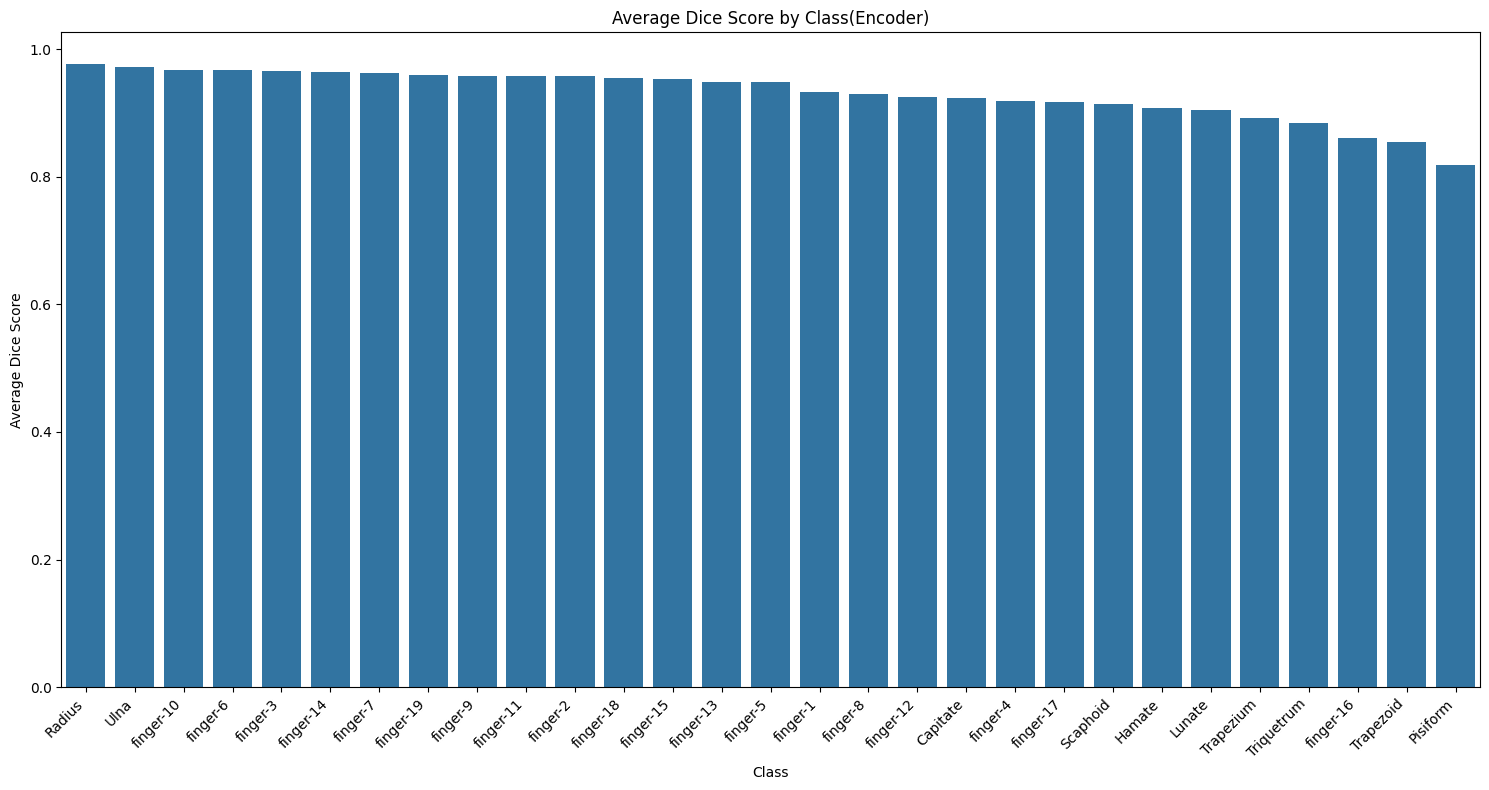

In [18]:

# Decoder 비교 
# 클래스별 평균 Dice 점수 계산
class_mean_dice = enc_class_dice_df.groupby('class')['dice'].mean().sort_values(ascending=False)

# 시각화
plt.figure(figsize=(15, 8))
sns.barplot(x=class_mean_dice.index, y=class_mean_dice.values)
plt.xticks(rotation=45, ha='right')
plt.title('Average Dice Score by Class(Encoder)')
plt.xlabel('Class')
plt.ylabel('Average Dice Score')
plt.tight_layout()
plt.show()

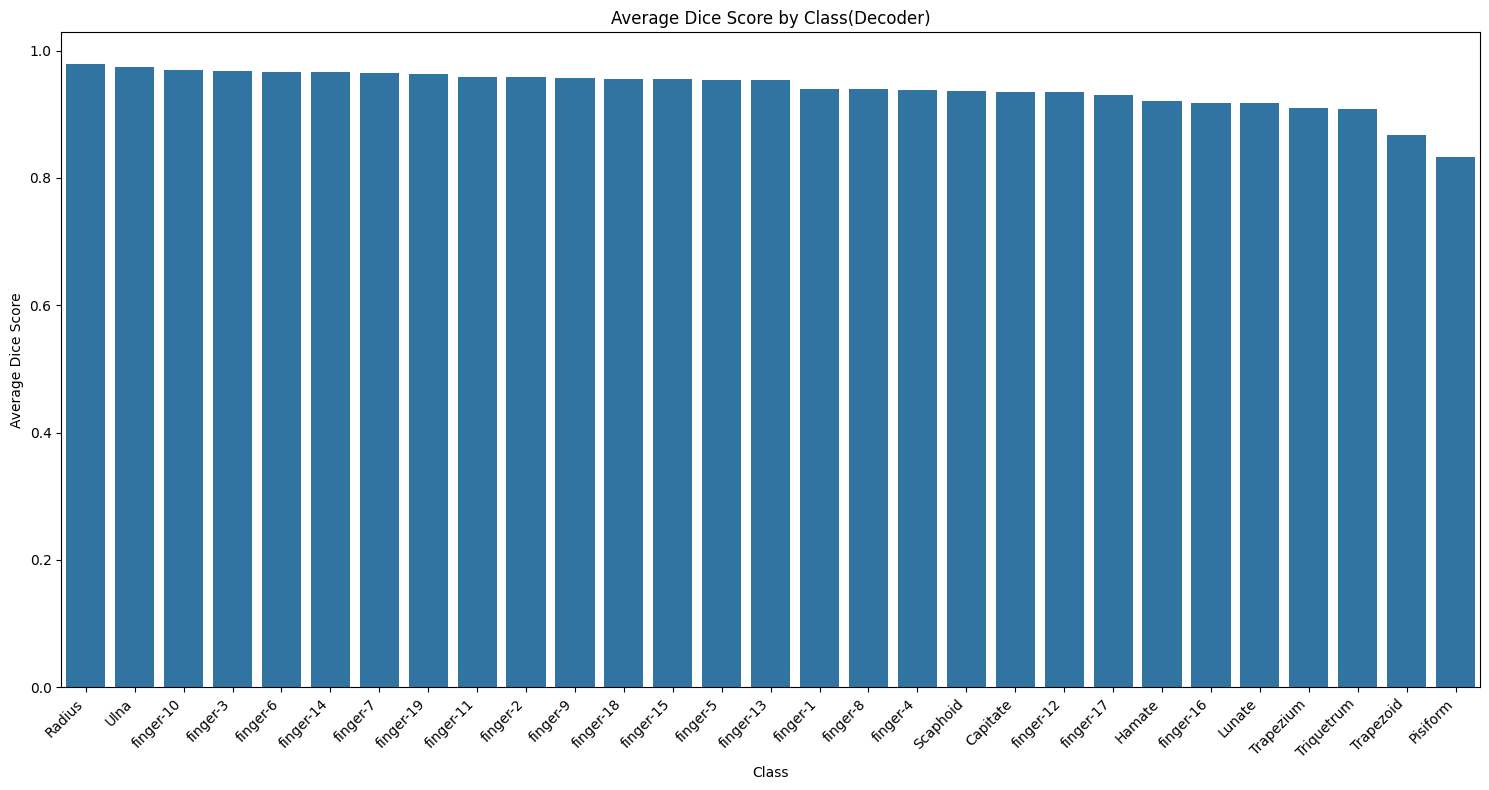

In [19]:

# Decoder 비교 
# 클래스별 평균 Dice 점수 계산
class_mean_dice = dec_class_dice_df.groupby('class')['dice'].mean().sort_values(ascending=False)

# 시각화
plt.figure(figsize=(15, 8))
sns.barplot(x=class_mean_dice.index, y=class_mean_dice.values)
plt.xticks(rotation=45, ha='right')
plt.title('Average Dice Score by Class(Decoder)')
plt.xlabel('Class')
plt.ylabel('Average Dice Score')
plt.tight_layout()
plt.show()


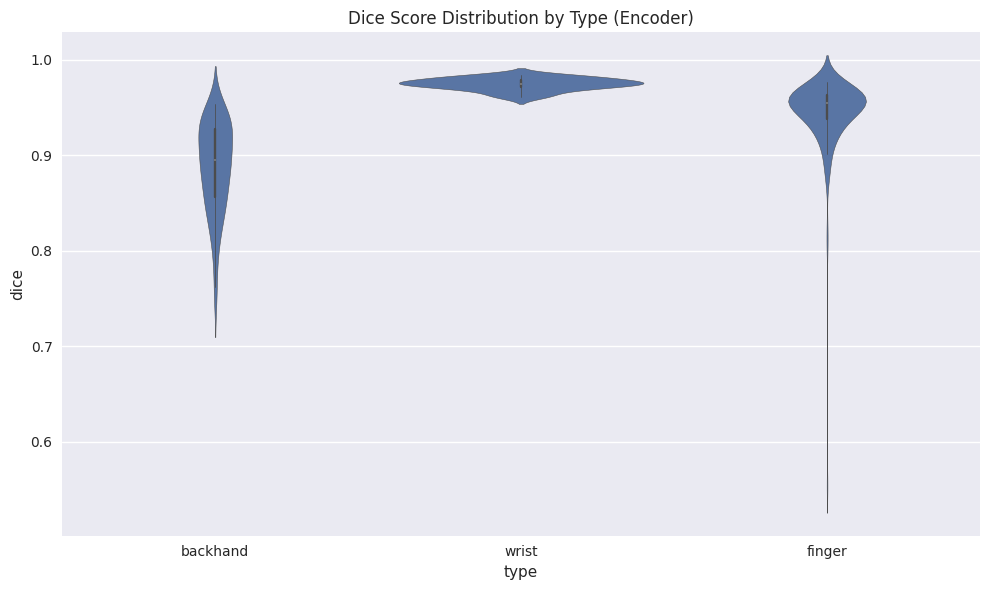

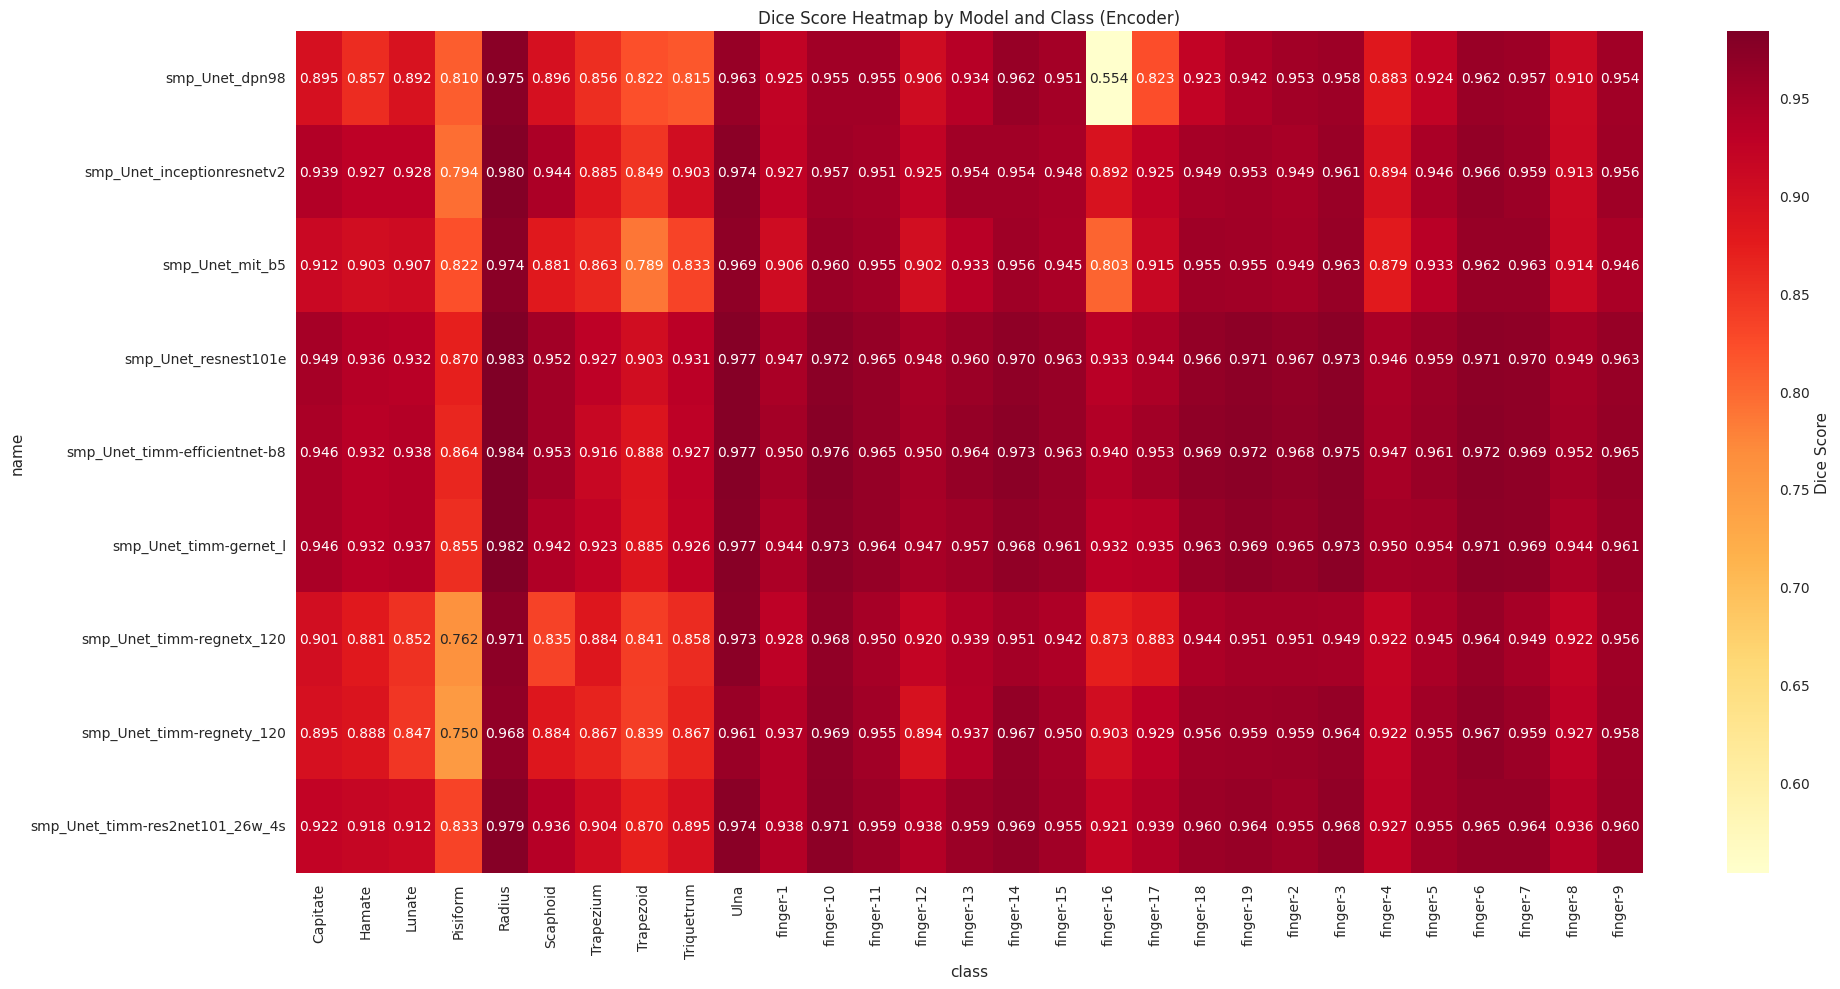

In [20]:

# Encoder
# 전체 시각화 스타일 설정
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [15, 10]

# 타입별 성능 분포 (Violin Plot)
plt.figure(figsize=(10, 6))
sns.violinplot(data=enc_class_dice_df, x='type', y='dice')
plt.title('Dice Score Distribution by Type (Encoder)')
plt.tight_layout()
plt.show()

# 히트맵: 모델별 클래스별 성능
pivot_table = enc_class_dice_df.pivot(index='name', columns='class', values='dice')
plt.figure(figsize=(20, 10))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.3f', cbar_kws={'label': 'Dice Score'})
plt.title('Dice Score Heatmap by Model and Class (Encoder)')
plt.tight_layout()
plt.show()

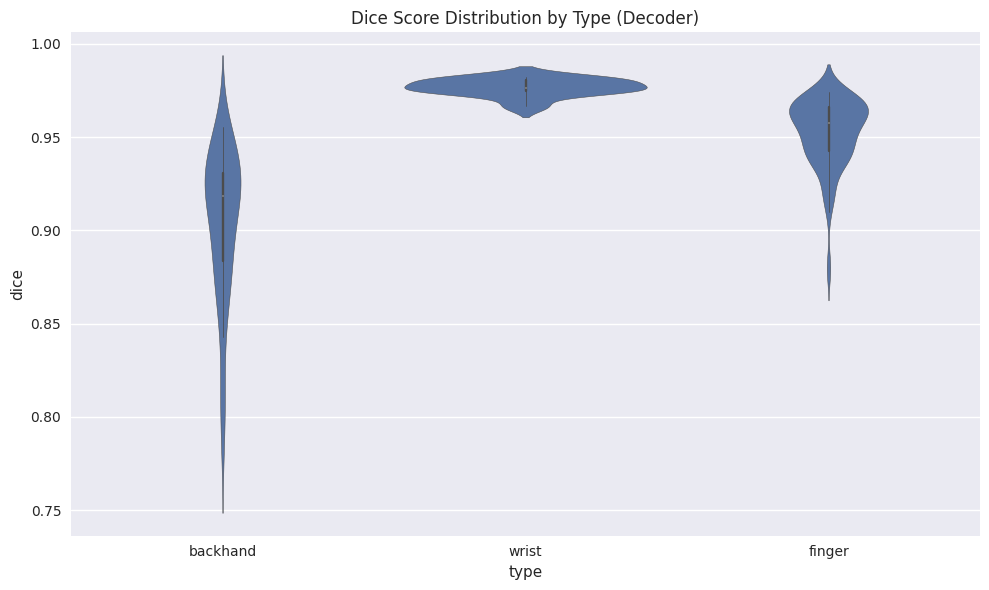

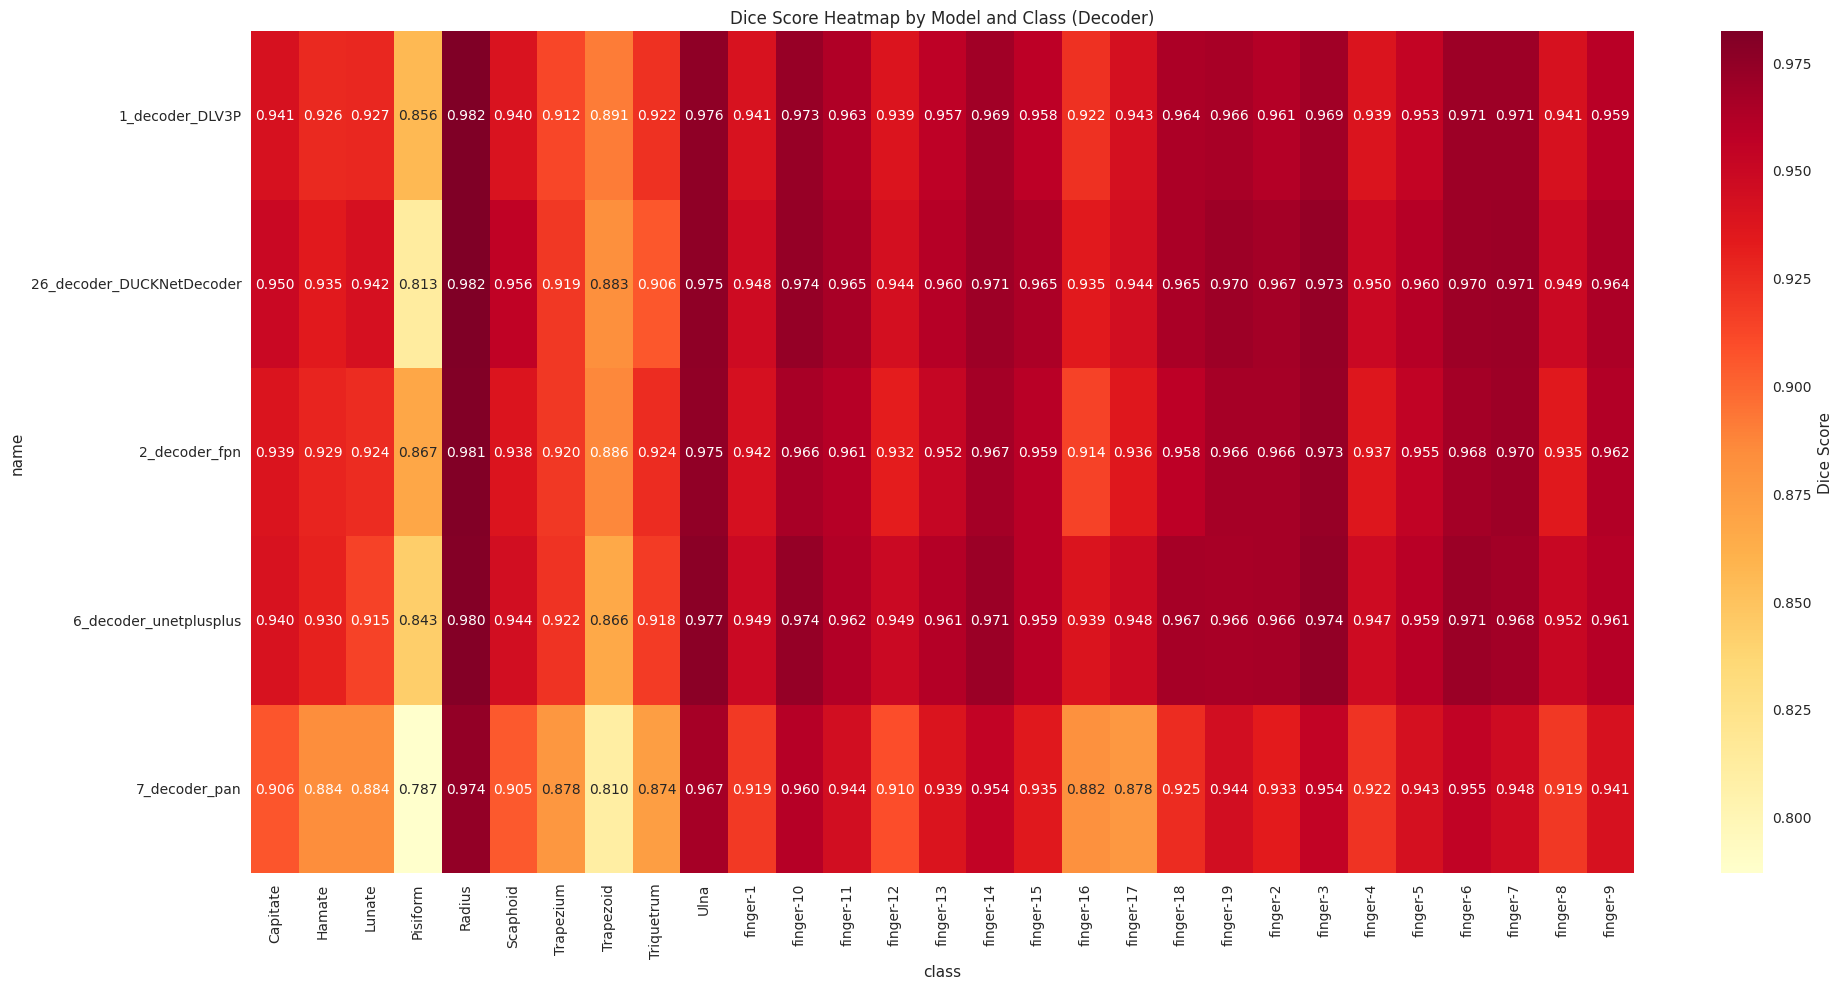

In [21]:

# Decoder
# 전체 시각화 스타일 설정
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [15, 10]

# 타입별 성능 분포 (Violin Plot)
plt.figure(figsize=(10, 6))
sns.violinplot(data=dec_class_dice_df, x='type', y='dice')
plt.title('Dice Score Distribution by Type (Decoder)')
plt.tight_layout()
plt.show()

# 히트맵: 모델별 클래스별 성능
pivot_table = dec_class_dice_df.pivot(index='name', columns='class', values='dice')
plt.figure(figsize=(20, 10))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.3f', cbar_kws={'label': 'Dice Score'})
plt.title('Dice Score Heatmap by Model and Class (Decoder)')
plt.tight_layout()
plt.show()


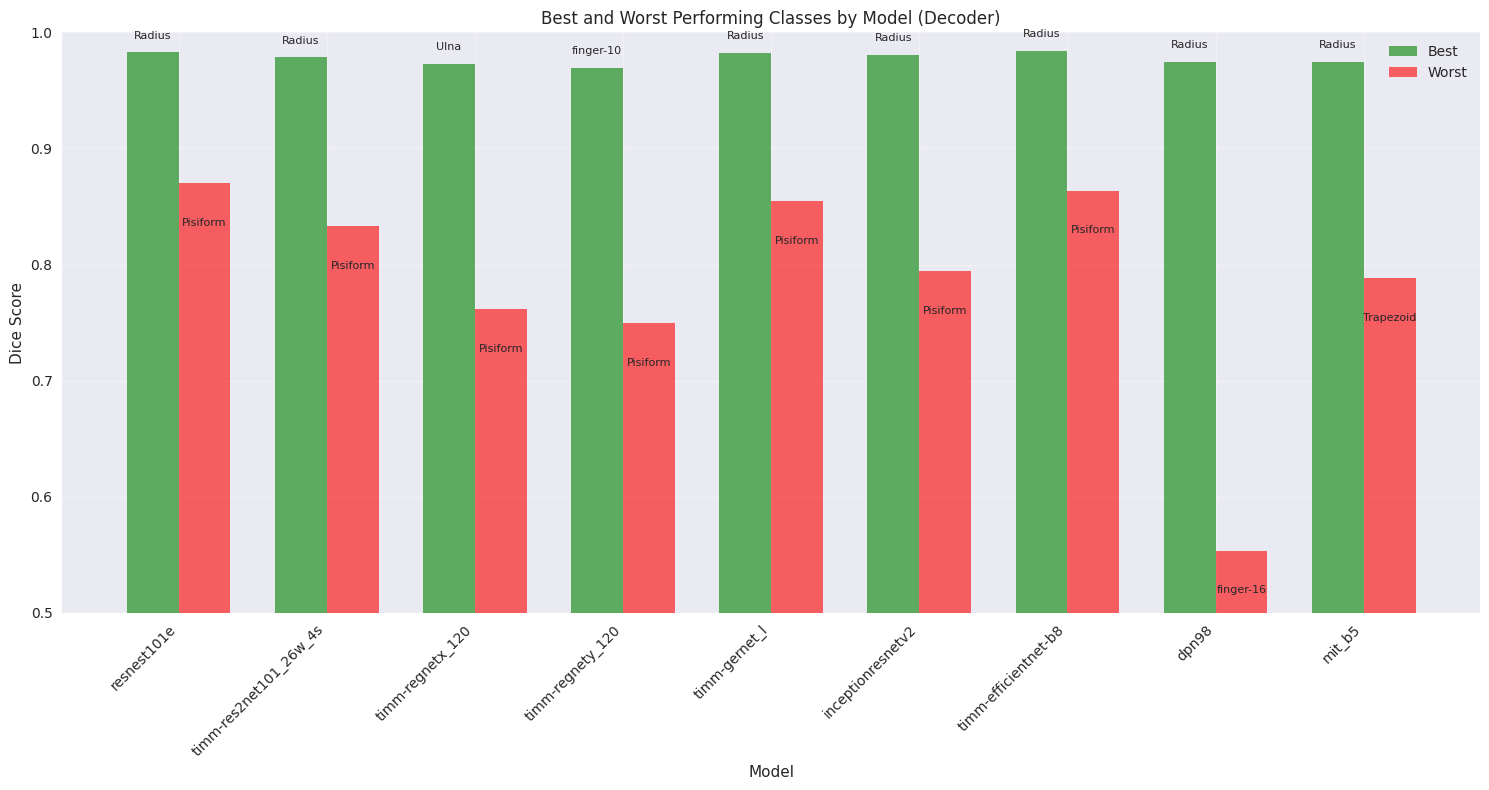


Detailed Results:

Model: resnest101e
Best Class: Radius (Dice: 0.9828)
Worst Class: Pisiform (Dice: 0.8703)

Model: timm-res2net101_26w_4s
Best Class: Radius (Dice: 0.9786)
Worst Class: Pisiform (Dice: 0.8331)

Model: timm-regnetx_120
Best Class: Ulna (Dice: 0.9730)
Worst Class: Pisiform (Dice: 0.7617)

Model: timm-regnety_120
Best Class: finger-10 (Dice: 0.9692)
Worst Class: Pisiform (Dice: 0.7495)

Model: timm-gernet_l
Best Class: Radius (Dice: 0.9824)
Worst Class: Pisiform (Dice: 0.8546)

Model: inceptionresnetv2
Best Class: Radius (Dice: 0.9804)
Worst Class: Pisiform (Dice: 0.7944)

Model: timm-efficientnet-b8
Best Class: Radius (Dice: 0.9839)
Worst Class: Pisiform (Dice: 0.8637)

Model: dpn98
Best Class: Radius (Dice: 0.9746)
Worst Class: finger-16 (Dice: 0.5537)

Model: mit_b5
Best Class: Radius (Dice: 0.9744)
Worst Class: Trapezoid (Dice: 0.7887)


In [22]:
# Encoder
# 모델별 최고/최저 성능 클래스 찾기
encoder_extremes = []

for model in enc_class_dice_df['name'].unique():
    model_data = enc_class_dice_df[enc_class_dice_df['name'] == model]
    
    # 최고 성능 클래스
    best_class = model_data.loc[model_data['dice'].idxmax()]
    # 최저 성능 클래스
    worst_class = model_data.loc[model_data['dice'].idxmin()]
    
    encoder_extremes.append({
        'model': model.replace('smp_Unet_', ''),  # 모델명 간소화
        'best_class': best_class['class'],
        'best_dice': best_class['dice'],
        'worst_class': worst_class['class'],
        'worst_dice': worst_class['dice']
    })

# DataFrame 생성
enc_extremes_df = pd.DataFrame(encoder_extremes)

# 시각화
plt.figure(figsize=(15, 8))

x = np.arange(len(enc_extremes_df))
width = 0.35

# 최고 성능
plt.bar(x - width/2, enc_extremes_df['best_dice'], width, label='Best', color='green', alpha=0.6)
# 최저 성능
plt.bar(x + width/2, enc_extremes_df['worst_dice'], width, label='Worst', color='red', alpha=0.6)

# 클래스 이름 표시
for i, row in enc_extremes_df.iterrows():
    # 최고 성능 클래스 이름
    plt.text(i - width/2, row['best_dice'] + 0.01, row['best_class'],
             ha='center', va='bottom', fontsize=8)
    # 최저 성능 클래스 이름
    plt.text(i + width/2, row['worst_dice'] - 0.03, row['worst_class'],
             ha='center', va='top', fontsize=8)

plt.xlabel('Model')
plt.ylabel('Dice Score')
plt.title('Best and Worst Performing Classes by Model (Decoder)')
plt.xticks(x, enc_extremes_df['model'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# y축 범위 설정
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

# 결과를 표로도 출력
print("\nDetailed Results:")
for _, row in enc_extremes_df.iterrows():
    print(f"\nModel: {row['model']}")
    print(f"Best Class: {row['best_class']} (Dice: {row['best_dice']:.4f})")
    print(f"Worst Class: {row['worst_class']} (Dice: {row['worst_dice']:.4f})")

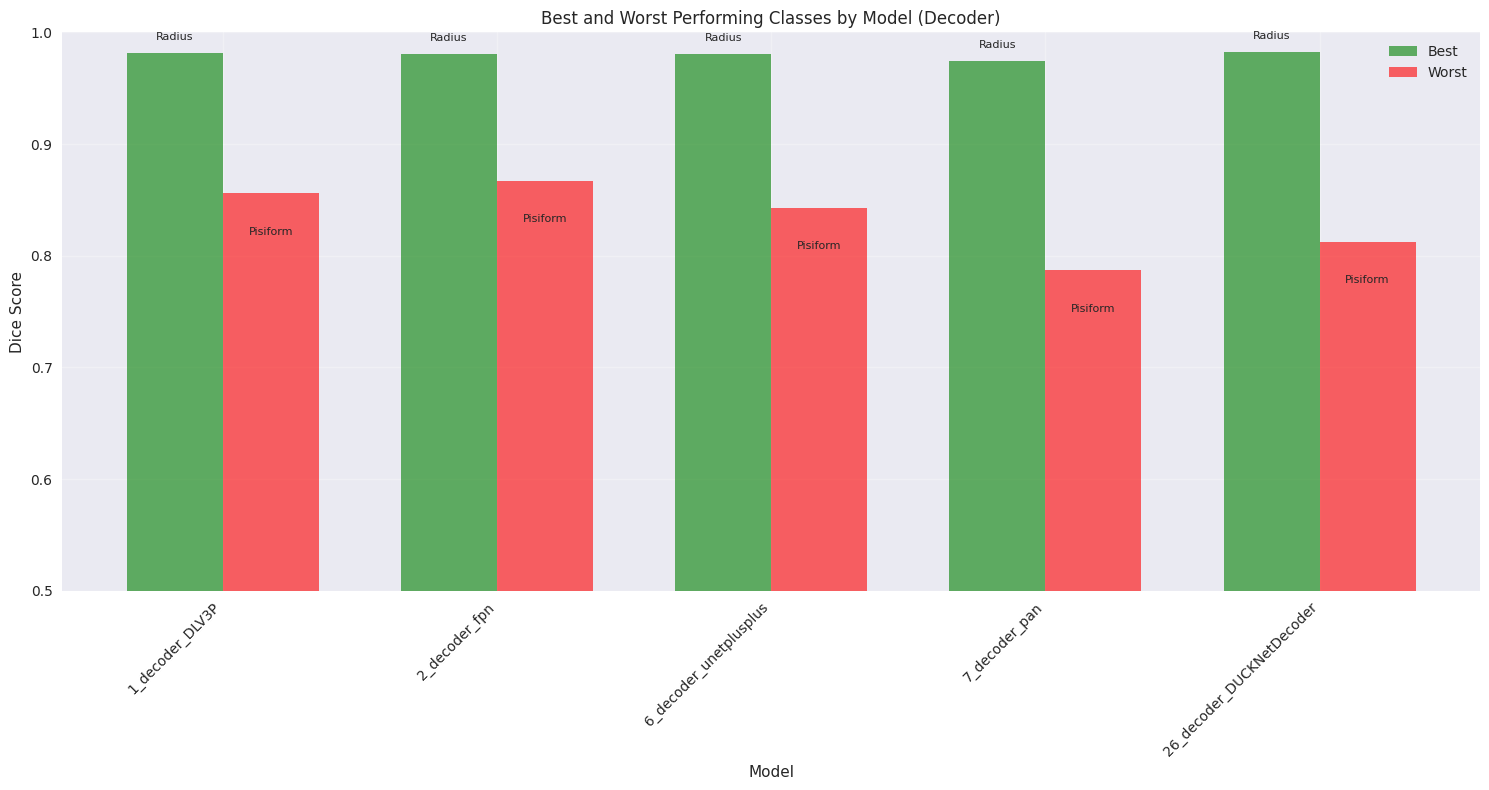


Detailed Results:

Model: 1_decoder_DLV3P
Best Class: Radius (Dice: 0.9816)
Worst Class: Pisiform (Dice: 0.8559)

Model: 2_decoder_fpn
Best Class: Radius (Dice: 0.9807)
Worst Class: Pisiform (Dice: 0.8670)

Model: 6_decoder_unetplusplus
Best Class: Radius (Dice: 0.9802)
Worst Class: Pisiform (Dice: 0.8428)

Model: 7_decoder_pan
Best Class: Radius (Dice: 0.9739)
Worst Class: Pisiform (Dice: 0.7870)

Model: 26_decoder_DUCKNetDecoder
Best Class: Radius (Dice: 0.9821)
Worst Class: Pisiform (Dice: 0.8125)


In [23]:
# Decoder
# 모델별 최고/최저 성능 클래스 찾기
decoder_extremes = []

for model in dec_class_dice_df['name'].unique():
    model_data = dec_class_dice_df[dec_class_dice_df['name'] == model]
    
    # 최고 성능 클래스
    best_class = model_data.loc[model_data['dice'].idxmax()]
    # 최저 성능 클래스
    worst_class = model_data.loc[model_data['dice'].idxmin()]
    
    decoder_extremes.append({
        'model': model.replace('smp_Unet_', ''),  # 모델명 간소화
        'best_class': best_class['class'],
        'best_dice': best_class['dice'],
        'worst_class': worst_class['class'],
        'worst_dice': worst_class['dice']
    })

# DataFrame 생성
dec_extremes_df = pd.DataFrame(decoder_extremes)

# 시각화
plt.figure(figsize=(15, 8))

x = np.arange(len(dec_extremes_df))
width = 0.35

# 최고 성능
plt.bar(x - width/2, dec_extremes_df['best_dice'], width, label='Best', color='green', alpha=0.6)
# 최저 성능
plt.bar(x + width/2, dec_extremes_df['worst_dice'], width, label='Worst', color='red', alpha=0.6)

# 클래스 이름 표시
for i, row in dec_extremes_df.iterrows():
    # 최고 성능 클래스 이름
    plt.text(i - width/2, row['best_dice'] + 0.01, row['best_class'],
             ha='center', va='bottom', fontsize=8)
    # 최저 성능 클래스 이름
    plt.text(i + width/2, row['worst_dice'] - 0.03, row['worst_class'],
             ha='center', va='top', fontsize=8)

plt.xlabel('Model')
plt.ylabel('Dice Score')
plt.title('Best and Worst Performing Classes by Model (Decoder)')
plt.xticks(x, dec_extremes_df['model'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# y축 범위 설정
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.show()

# 결과를 표로도 출력
print("\nDetailed Results:")
for _, row in dec_extremes_df.iterrows():
    print(f"\nModel: {row['model']}")
    print(f"Best Class: {row['best_class']} (Dice: {row['best_dice']:.4f})")
    print(f"Worst Class: {row['worst_class']} (Dice: {row['worst_dice']:.4f})")

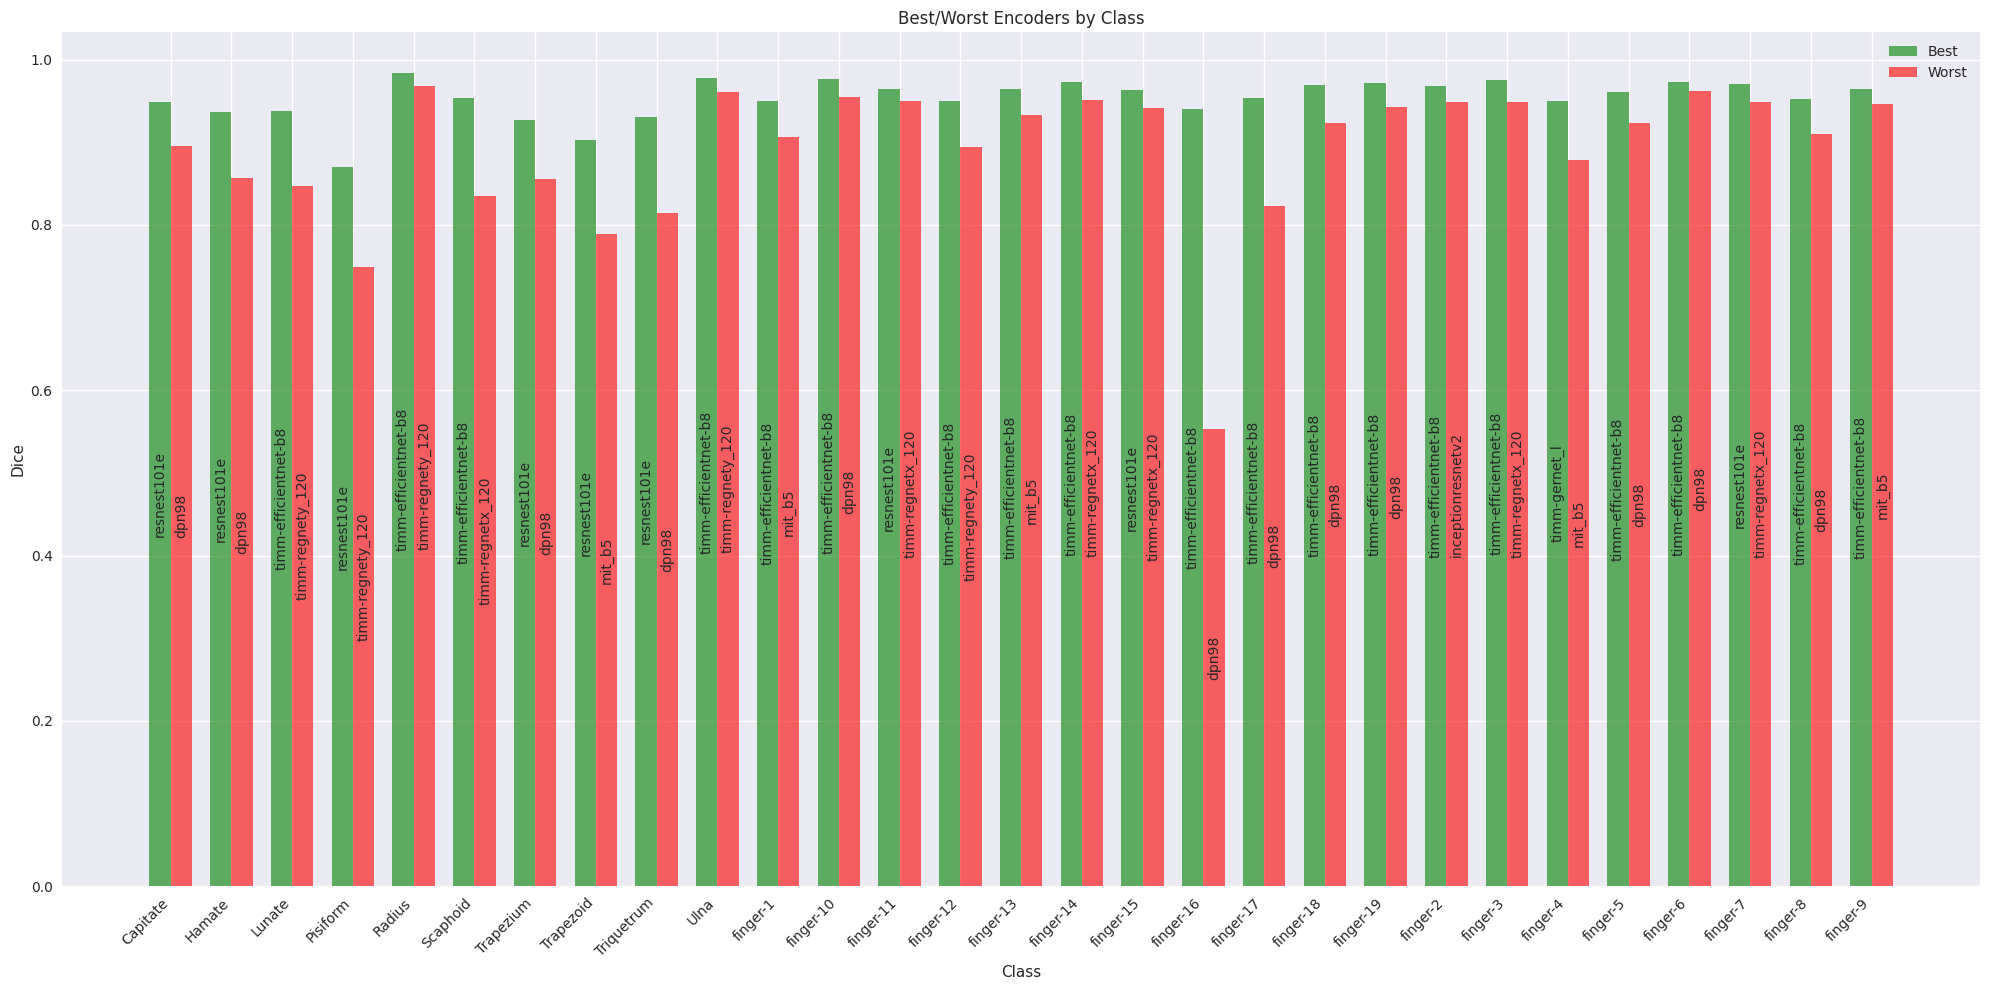

In [24]:
# Encoder
# 각 클래스별 최고/최저 성능 모델 찾기
best_encoder = enc_class_dice_df.loc[enc_class_dice_df.groupby('class')['dice'].idxmax()]
worst_encoder = enc_class_dice_df.loc[enc_class_dice_df.groupby('class')['dice'].idxmin()]

# 시각화
plt.figure(figsize=(20, 10))

# 데이터 준비
classes = best_encoder['class'].unique()
x = np.arange(len(classes))
width = 0.35

# 막대 그래프 그리기
rects1 = plt.bar(x - width/2, best_encoder['dice'], width, label='Best', color='green', alpha=0.6)
rects2 = plt.bar(x + width/2, worst_encoder['dice'], width, label='Worst', color='red', alpha=0.6)

# 그래프 꾸미기
plt.xlabel('Class')
plt.ylabel('Dice')
plt.title('Best/Worst Encoders by Class')
plt.xticks(x, classes, rotation=45, ha='right')
plt.legend()

# 최고/최저 성능 모델 이름 표시
for rect1, rect2, best, worst in zip(rects1, rects2, best_encoder['name'], worst_encoder['name']):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    
    # 최고 성능 모델 이름 표시
    plt.text(rect1.get_x() + rect1.get_width()/2, height1/2,
             best.replace('smp_Unet_', ''),
             rotation=90, ha='center', va='center', fontsize=10)
    
    # 최저 성능 모델 이름 표시
    plt.text(rect2.get_x() + rect2.get_width()/2, height2/2,
             worst.replace('smp_Unet_', ''),
             rotation=90, ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()


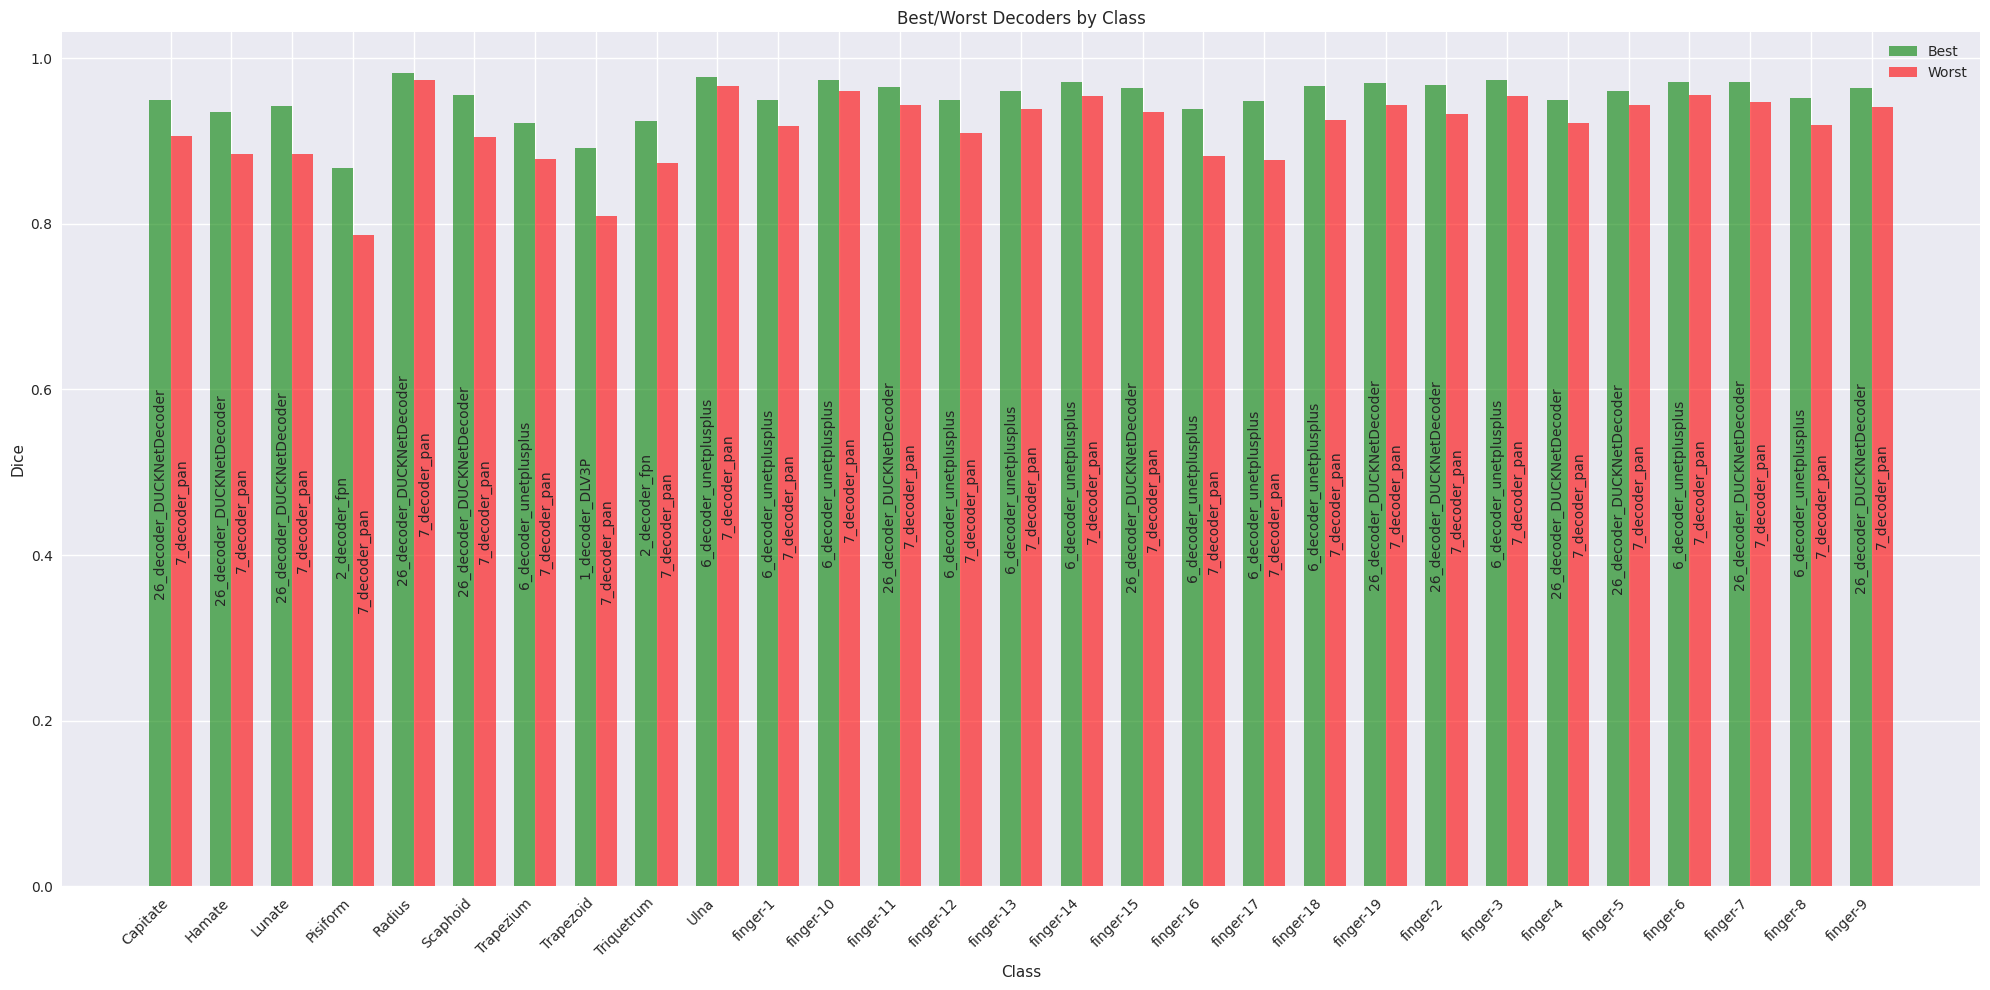

In [25]:
# Decoder
# 각 클래스별 최고/최저 성능 모델 찾기
best_decoder = dec_class_dice_df.loc[dec_class_dice_df.groupby('class')['dice'].idxmax()]
worst_decoder = dec_class_dice_df.loc[dec_class_dice_df.groupby('class')['dice'].idxmin()]

# 시각화
plt.figure(figsize=(20, 10))

# 데이터 준비
classes = best_decoder['class'].unique()
x = np.arange(len(classes))
width = 0.35

# 막대 그래프 그리기
rects1 = plt.bar(x - width/2, best_decoder['dice'], width, label='Best', color='green', alpha=0.6)
rects2 = plt.bar(x + width/2, worst_decoder['dice'], width, label='Worst', color='red', alpha=0.6)

# 그래프 꾸미기
plt.xlabel('Class')
plt.ylabel('Dice')
plt.title('Best/Worst Decoders by Class')
plt.xticks(x, classes, rotation=45, ha='right')
plt.legend()

# 최고/최저 성능 모델 이름 표시
for rect1, rect2, best, worst in zip(rects1, rects2, best_decoder['name'], worst_decoder['name']):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    
    # 최고 성능 모델 이름 표시
    plt.text(rect1.get_x() + rect1.get_width()/2, height1/2,
             best.replace('smp_Unet_', ''),
             rotation=90, ha='center', va='center', fontsize=10)
    
    # 최저 성능 모델 이름 표시
    plt.text(rect2.get_x() + rect2.get_width()/2, height2/2,
             worst.replace('smp_Unet_', ''),
             rotation=90, ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.show()


In [26]:
best_decoder

,class,dice,type,name
116,Capitate,0.949505,backhand,26_decoder_DUCKNetDecoder
117,Hamate,0.934678,backhand,26_decoder_DUCKNetDecoder
118,Lunate,0.941772,backhand,26_decoder_DUCKNetDecoder
32,Pisiform,0.867010,backhand,2_decoder_fpn
120,Radius,0.982135,wrist,26_decoder_DUCKNetDecoder
121,Scaphoid,0.955586,backhand,26_decoder_DUCKNetDecoder
64,Trapezium,0.921610,backhand,6_decoder_unetplusplus
7,Trapezoid,0.891094,backhand,1_decoder_DLV3P
37,Triquetrum,0.924224,backhand,2_decoder_fpn
67,Ulna,0.976966,wrist,6_decoder_unetplusplus


In [27]:
worst_decoder

,class,dice,type,name
87,Capitate,0.906241,backhand,7_decoder_pan
88,Hamate,0.884201,backhand,7_decoder_pan
89,Lunate,0.883870,backhand,7_decoder_pan
90,Pisiform,0.786953,backhand,7_decoder_pan
91,Radius,0.973941,wrist,7_decoder_pan
92,Scaphoid,0.904906,backhand,7_decoder_pan
93,Trapezium,0.878245,backhand,7_decoder_pan
94,Trapezoid,0.809956,backhand,7_decoder_pan
95,Triquetrum,0.873860,backhand,7_decoder_pan
96,Ulna,0.966623,wrist,7_decoder_pan
